# Custom model-graded evals 

**Note: This lesson lives in a folder that contains relevant code files. Download the entire folder if you want to follow along and run the evaluation yourself**


In this lesson, we'll see how we can write custom model-graded evaluations using promptfoo. We'll start with a simple prompting goal: we want to write a prompt that can turn long, technically complex Wikipedia articles into short summaries appropriate for a grade school audience.

For example, given the entire [Wikipedia entry on convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network), we want simple output summary like this one:

> Convolutional neural networks, or CNNs, are a special type of computer program that can learn to recognize images and patterns. They work a bit like the human brain, using layers of artificial "neurons" to process information.
CNNs are really good at tasks like identifying objects in pictures or recognizing faces. They do this by breaking down images into smaller pieces and looking for important features, kind of like putting together a puzzle.
What makes CNNs special is that they can learn these features on their own by looking at lots of examples. This allows them to get better and better at recognizing things, sometimes even matching human-level performance.
Scientists and engineers use CNNs for all sorts of cool applications, like helping self-driving cars see the road, finding new medicines, or even teaching computers to play games like chess and Go.

To evaluate the effectiveness of our prompts, we're going to write a custom model-graded assertion that assesses a resulting summary across three metrics:

* Conciseness (1-5) - is the summary as concise as possible?
* Accuracy (1-5) - is the summary completely accurate based on the initial article'?
* Tone (1-5) - is the summary appropriate for a grade school student with no technical training?

Each of these metrics will result in a score between 1 and 5.  We'll average them together and aim for an average score of at least 4.5/5. To do this, we'll define a custom model-grader function!

---
    


## The input data

Our goal is to write a prompt to summarize complex Wikipedia articles into short, easy to understand summaries.  We'll start by collecting the articles we want to summarize as part of our evaluation.

In this folder we've provided an `articles` directory than contains eight different txt files.  Each file contains the text content from a Wikipedia article.   We'll use these articles as the inputs in our evaluation. Take a look at some of the article files to get a sense of how long and complex they are.

This dataset consists of only eight test cases, which is far too small for a real-world evaluation.  As we've mentioned many times throughout this course, we highly recommend using evaluation dataset of at least 100 entries.

---

## Our prompts

Take a look at the `prompts.py` file. It contains three different prompt-generating functions that we'll evaluate using promptfoo:

```py
def basic_summarize(article):
  return f"Summarize this article {article}"

def better_summarize(article):
  return f"""
  Summarize this article for a grade-school audience: {article}"""

def best_summarize(article):
  return f"""
  You are tasked with summarizing long wikipedia articles for a grade-school audience.
  Write a short summary, keeping it as concise as possible. 
  The summary is intended for a non-technical, grade-school audience. 
  This is the article: {article}"""
```
**It's important to note than these prompts are all generally mediocre prompts.  We kept the prompts deliberately short and did not follow best practices, like adding in comprehensive examples, to minimize the number of tokens used when running this evaluation set.** 

---

## Updating the config file

The `promptfooconfig.yaml` file contains fields we've mostly seen before:


```yaml
description: 'Summarization Evaluation'

prompts:
  - prompts.py:basic_summarize
  - prompts.py:better_summarize
  - prompts.py:best_summarize

providers:
  - id: anthropic:messages:claude-3-5-sonnet-20240620
    label: "3.5 Sonnet"

tests:
  - vars:
      article: file://articles/article1.txt
  - vars:
      article: file://articles/article2.txt
  - vars:
      article: file://articles/article3.txt
  - vars:
      article: file://articles/article4.txt
  - vars:
      article: file://articles/article5.txt
  - vars:
      article: file://articles/article6.txt
  - vars:
      article: file://articles/article7.txt
  - vars:
      article: file://articles/article8.txt

defaultTest:
  assert:
    - type: python
      value: file://custom_llm_eval.py

```

We're telling promptfoo that we want to use each of the three prompts we defined in `prompts.py`.  Next, we configure promptfoo to use Claude 3.5 Sonnet as the provider.

We're writing a series of `tests` where we provide a different value for `article` in each test.  The one thing that is new here is that we're loading the values from a text file.  The articles are so long, it didn't make sense to put them inline in the YAML file.  For example, this bit of the configuration file: 

```yaml
tests:
  - vars:
      article: file://articles/article1.txt
```

tells promptfoo we want to run a test where the `article` variable is set to the text contents of the `article1.txt` file.  We repeat this process for all of the eight article files.

---

## Writing the custom model-grader function

Next, lets turn our attention to the very last field in the YAML file:

```yaml
defaultTest:
  assert:
    - type: python
      value: file://custom_llm_eval.py
```

This field tells promptfoo that for every single test, we want to run a particular python assertion we've defined in the file `custom_llm_eval.py`.  We've seen this syntax before when defining a custom code-graded assertion.  The only difference is that this time we're going to write a function that grades a model's output using another model.

Let's take a look at the contents of the `custom_llm_eval.py` file.  It contains quite a bit of code:

```py
import anthropic
import os
import json

def llm_eval(summary, article):
    client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

    prompt = f"""Evaluate the following summary based on these criteria:
    1. Conciseness (1-5) - is the summary as concise as possible?
        - Conciseness of 1: The summary is unnecessarily long, including excessive details, repetitions, or irrelevant information. It fails to distill the key points effectively.
        - Conciseness of 3:  The summary captures most key points but could be more focused. It may include some unnecessary details or slightly over explain certain concepts.
        - Conciseness of 5: The summary effectively condenses the main ideas into a brief, focused text. It includes all essential information without any superfluous details or explanations.
    2. Accuracy (1-5) - is the summary completely accurate based on the initial article'?
        - Accuracy of 1: The summary contains significant errors, misrepresentations, or omissions that fundamentally alter the meaning or key points of the original article.
        - Accuracy of 3:  The summary captures some key points correctly but may have minor inaccuracies or omissions. The overall message is generally correct, but some details may be wrong.
        - Accuracy of 5: The summary faithfully represents the main gist of the original article without any errors or misinterpretations. All included information is correct and aligns with the source material.
    3. Tone (1-5) - is the summary appropriate for a grade school student with no technical training?
        - Tone of 1: The summary uses language or concepts that are too complex, technical, or mature for a grade school audience. It may contain jargon, advanced terminology, or themes that are not suitable for young readers.
        - Tone of 2:  The summary mostly uses language suitable for grade school students but occasionally includes terms or concepts that may be challenging. Some explanations might be needed for full comprehension.
        - Tone of 3: The summary consistently uses simple, clear language that is easily understandable by grade school students. It explains complex ideas in a way that is accessible and engaging for young readers.
    4. Explanation - a general description of the way the summary is evaluated

    <examples>
    <example>
    This summary:
    <summary>
    Artificial neural networks are computer systems inspired by how the human brain works. They are made up of interconnected "neurons" that process information. These networks can learn to do tasks by looking at lots of examples, similar to how humans learn. 

    Some key things about neural networks:
    - They can recognize patterns and make predictions
    - They improve with more data and practice
    - They're used for things like identifying objects in images, translating languages, and playing games

    Neural networks are a powerful tool in artificial intelligence and are behind many of the "smart" technologies we use today. While they can do amazing things, they still aren't as complex or capable as the human brain.
    <summary>
    Should receive a 5 for tone, a 5 for accuracy, and a 5 for conciseness
    </example>

    <example>
    This summary:
    <summary>
    Here is a summary of the key points from the article on artificial neural networks (ANNs):

    1. ANNs are computational models inspired by biological neural networks in animal brains. They consist of interconnected artificial neurons that process and transmit signals.

    2. Basic structure:
    - Input layer receives data
    - Hidden layers process information 
    - Output layer produces results
    - Neurons are connected by weighted edges

    3. Learning process:
    - ANNs learn by adjusting connection weights
    - Use techniques like backpropagation to minimize errors
    - Can perform supervised, unsupervised, and reinforcement learning

    4. Key developments:
    - Convolutional neural networks (CNNs) for image processing
    - Recurrent neural networks (RNNs) for sequential data
    - Deep learning with many hidden layers

    5. Applications:
    - Pattern recognition, classification, regression
    - Computer vision, speech recognition, natural language processing
    - Game playing, robotics, financial modeling

    6. Advantages:
    - Can model complex non-linear relationships
    - Ability to learn and generalize from data
    - Adaptable to many different types of problems

    7. Challenges:
    - Require large amounts of training data
    - Can be computationally intensive
    - "Black box" nature can make interpretability difficult

    8. Recent advances:
    - Improved hardware (GPUs) enabling deeper networks
    - New architectures like transformers for language tasks
    - Progress in areas like generative AI

    The article provides a comprehensive overview of ANN concepts, history, types, applications, and ongoing research areas in this field of artificial intelligence and machine learning.
    </summary>
    Should receive a 1 for tone, a 5 for accuracy, and a 3 for conciseness
    </example>
    </examples>

    Provide a score for each criterion in JSON format. Here is the format you should follow always:

    <json>
    {{
    "conciseness": <number>,
    "accuracy": <number>,
    "tone": <number>,
    "explanation": <string>,
    }}
    </json>


    Original Text: <original_article>{article}</original_article>
    
    Summary to Evaluate: <summary>{summary}</summary>
    """
    
    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1000,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": prompt
            },
            {
                "role": "assistant",
                "content": "<json>" 
            }
        ],
        stop_sequences=["</json>"]
    )
    
    evaluation = json.loads(response.content[0].text)
    # Filter out non-numeric values and calculate the average
    numeric_values = [value for key, value in evaluation.items() if isinstance(value, (int, float))]
    avg_score = sum(numeric_values) / len(numeric_values)
    return avg_score, response.content[0].text

def get_assert(output: str, context, threshold=4.5):
    article = context['vars']['article']
    score, evaluation = llm_eval(output, article )
    return {
        "pass": score >= threshold,
        "score": score,
        "reason": evaluation
    }

```

### `get_assert()`

There's a lot to discuss here, but let's begin with the function at the bottom of the file: `get_assert`

```py
def get_assert(output: str, context, threshold=4.5):
    article = context['vars']['article']
    score, evaluation = llm_eval(output, article )
    return {
        "pass": score >= threshold,
        "score": score,
        "reason": evaluation
    }
```

Recall from our earlier lesson that promptfoo automatically looks for a function called `get_assert` in an assertion file.  It will pass the function the following two arguments:

- The `output` from a given model response
- The `context` dictionary that includes the variables and prompt that generated the output

Promptfoo expects our function to return one of the following:
- a bool (pass/fail)
- a float (score)
- a GradingResult dictionary

We've opted to return a GradingResult dictionary, which must include the following properties:

- `pass`: boolean
- `score`: float
- `reason`: a string explanation

Here's a commented version of the function that explains what's happening:

```py
def get_assert(output: str, context, threshold=4.5):
    # Get the specific article from the context
    article = context['vars']['article']
    #Pass the model output and the article to a function we've defined called llm_eval
    score, evaluation = llm_eval(output, article ) #capture the resulting score it returns and the evaluation explanation
    #return a dictionary indicating whether the output passed the test, its score, and the explanation behind the score
    return {
        "pass": score >= threshold,
        "score": score,
        "reason": evaluation
    }
```

### `llm_eval()`
Next, let's take a closer look at the `llm_eval` function that is doing the actual grading. The function does the following:

1. Defines a very long grading rubric prompt that explains how summaries should be scored
2. Runs the grading prompt by sending a request to the Anthropic API 
3. Parses the response and calculates an average score 
4. Returns the average score and the model's full text response

Here's the code in its entirety:

```py
def llm_eval(summary, article):
    """
    Evaluate summary using an LLM (Claude).
    
    Args:
    summary (str): The summary to evaluate.
    article (str): The original text that was summarized.
    
    Returns:
    bool: True if the average score is above the threshold, False otherwise.
    """
    client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

    prompt = f"""Evaluate the following summary based on these criteria:
    1. Conciseness (1-5) - is the summary as concise as possible?
        - Conciseness of 1: The summary is unnecessarily long, including excessive details, repetitions, or irrelevant information. It fails to distill the key points effectively.
        - Conciseness of 3:  The summary captures most key points but could be more focused. It may include some unnecessary details or slightly overexplain certain concepts.
        - Conciseness of 5: The summary effectively condenses the main ideas into a brief, focused text. It includes all essential information without any superfluous details or explanations.
    2. Accuracy (1-5) - is the summary completely accurate based on the initial article'?
        - Accuracy of 1: The summary contains significant errors, misrepresentations, or omissions that fundamentally alter the meaning or key points of the original article.
        - Accuracy of 3:  The summary captures some key points correctly but may have minor inaccuracies or omissions. The overall message is generally correct, but some details may be wrong.
        - Accuracy of 5: The summary faithfully represents the main gist of the original article without any errors or misinterpretations. All included information is correct and aligns with the source material.
    4. Tone (1-5) - is the summary appropriate for a grade school student with no technical training?
        - Tone of 1: The summary uses language or concepts that are too complex, technical, or mature for a grade school audience. It may contain jargon, advanced terminology, or themes that are not suitable for young readers.
        - Tone of 2:  The summary mostly uses language suitable for grade school students but occasionally includes terms or concepts that may be challenging. Some explanations might be needed for full comprehension.
        - Tone of 3: The summary consistently uses simple, clear language that is easily understandable by grade school students. It explains complex ideas in a way that is accessible and engaging for young readers.
    5. Explanation - a general description of the way the summary is evaluated

    <examples>
    <example>
    This summary:
    <summary>
    Artificial neural networks are computer systems inspired by how the human brain works. They are made up of interconnected "neurons" that process information. These networks can learn to do tasks by looking at lots of examples, similar to how humans learn. 

    Some key things about neural networks:
    - They can recognize patterns and make predictions
    - They improve with more data and practice
    - They're used for things like identifying objects in images, translating languages, and playing games

    Neural networks are a powerful tool in artificial intelligence and are behind many of the "smart" technologies we use today. While they can do amazing things, they still aren't as complex or capable as the human brain.
    <summary>
    Should receive a 5 for tone, a 5 for accuracy, and a 5 for conciseness
    </example>

    <example>
    This summary:
    <summary>
    Here is a summary of the key points from the article on artificial neural networks (ANNs):

    1. ANNs are computational models inspired by biological neural networks in animal brains. They consist of interconnected artificial neurons that process and transmit signals.

    2. Basic structure:
    - Input layer receives data
    - Hidden layers process information 
    - Output layer produces results
    - Neurons are connected by weighted edges

    3. Learning process:
    - ANNs learn by adjusting connection weights
    - Use techniques like backpropagation to minimize errors
    - Can perform supervised, unsupervised, and reinforcement learning

    4. Key developments:
    - Convolutional neural networks (CNNs) for image processing
    - Recurrent neural networks (RNNs) for sequential data
    - Deep learning with many hidden layers

    5. Applications:
    - Pattern recognition, classification, regression
    - Computer vision, speech recognition, natural language processing
    - Game playing, robotics, financial modeling

    6. Advantages:
    - Can model complex non-linear relationships
    - Ability to learn and generalize from data
    - Adaptable to many different types of problems

    7. Challenges:
    - Require large amounts of training data
    - Can be computationally intensive
    - "Black box" nature can make interpretability difficult

    8. Recent advances:
    - Improved hardware (GPUs) enabling deeper networks
    - New architectures like transformers for language tasks
    - Progress in areas like generative AI

    The article provides a comprehensive overview of ANN concepts, history, types, applications, and ongoing research areas in this field of artificial intelligence and machine learning.
    </summary>
    Should receive a 1 for tone, a 5 for accuracy, and a 3 for conciseness
    </example>
    </examples>

    Provide a score for each criterion in JSON format. Here is the format you should follow always:

    <json>
    {{
    "conciseness": <number>,
    "accuracy": <number>,
    "tone": <number>,
    "explanation": <string>,
    }}
    </json>


    Original Text: <original_article>{article}</original_article>
    
    Summary to Evaluate: <summary>{summary}</summary>
    """
    
    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1000,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": prompt
            },
            {
                "role": "assistant",
                "content": "<json>" 
            }
        ],
        stop_sequences=["</json>"]
    )
    
    evaluation = json.loads(response.content[0].text)
    # Filter out non-numeric values and calculate the average
    numeric_values = [value for key, value in evaluation.items() if isinstance(value, (int, float))]
    avg_score = sum(numeric_values) / len(numeric_values)
    # Return the average score and the overall model response
    return avg_score, response.content[0].text
```

---

## Running the eval

We use the same command we've seen before to run the evaluation: 

```bash
npx promptfoo@latest eval
```
This process can take a little while to complete because we're making the initial requests to the model to generate the article summaries and then sending additional requests to grade those summaries!

This is a screenshot of the evaluation result we got:

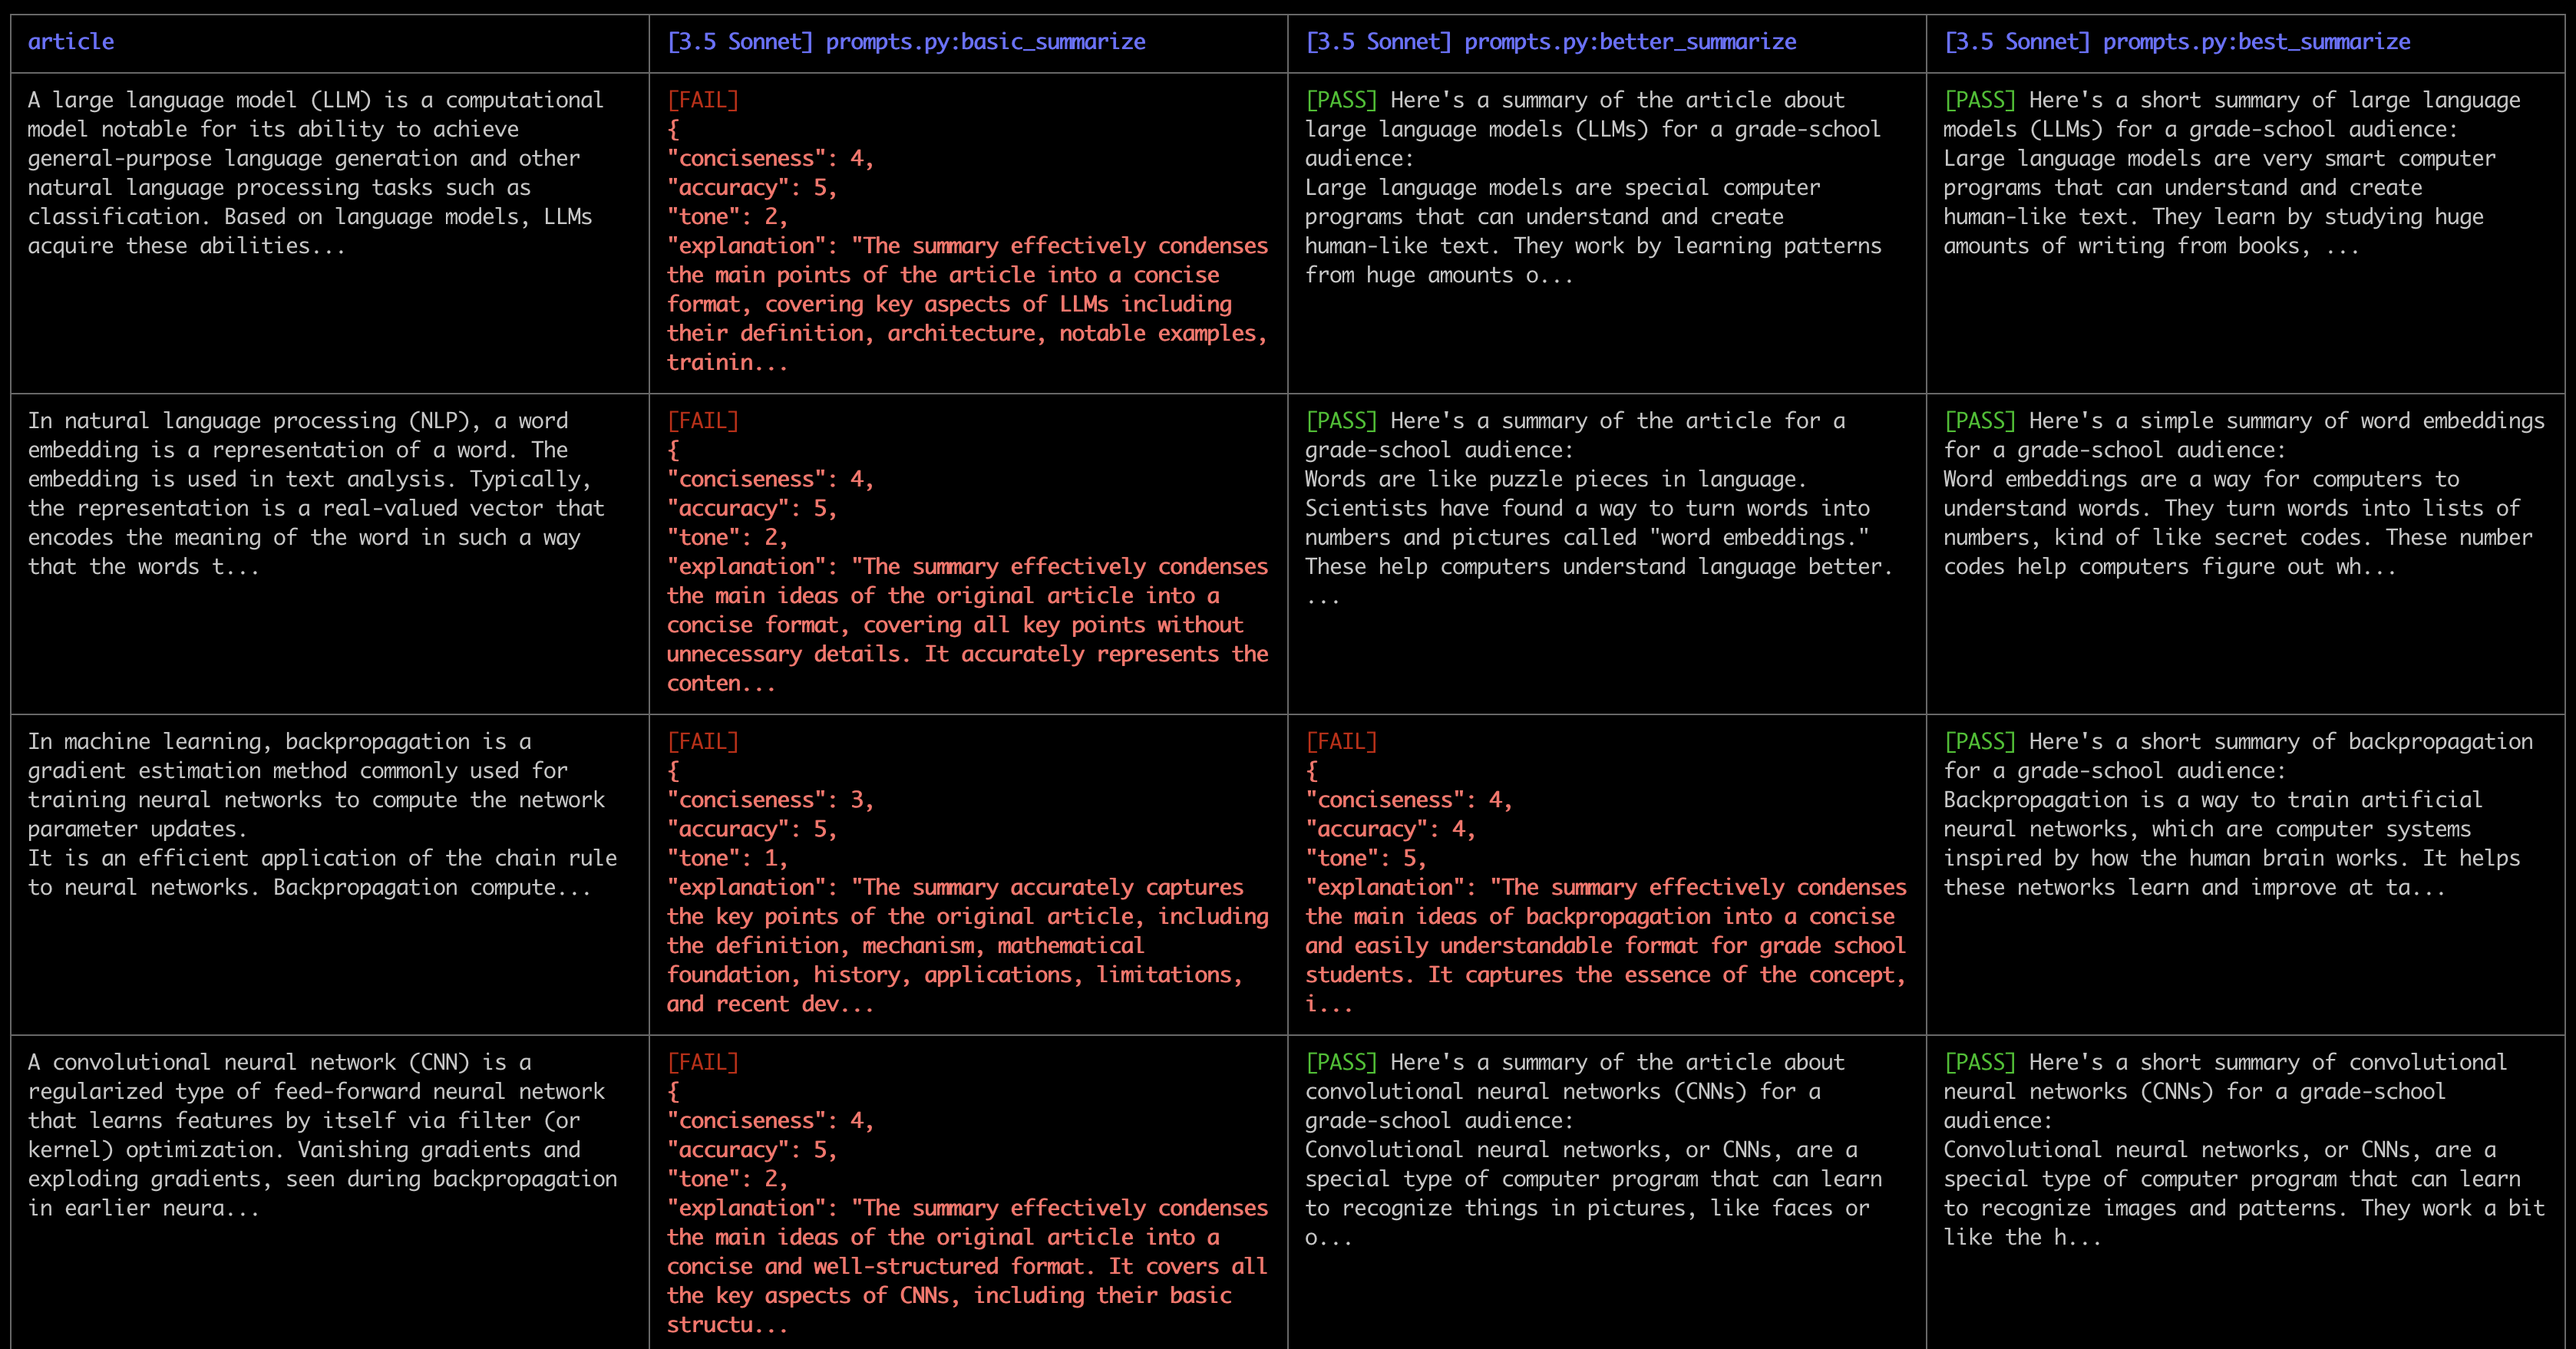

Let's launch the web view to get a better understanding of the results:

```bash
npx promptfoo@latest view
```
This is a screenshot of the web dashboard: 

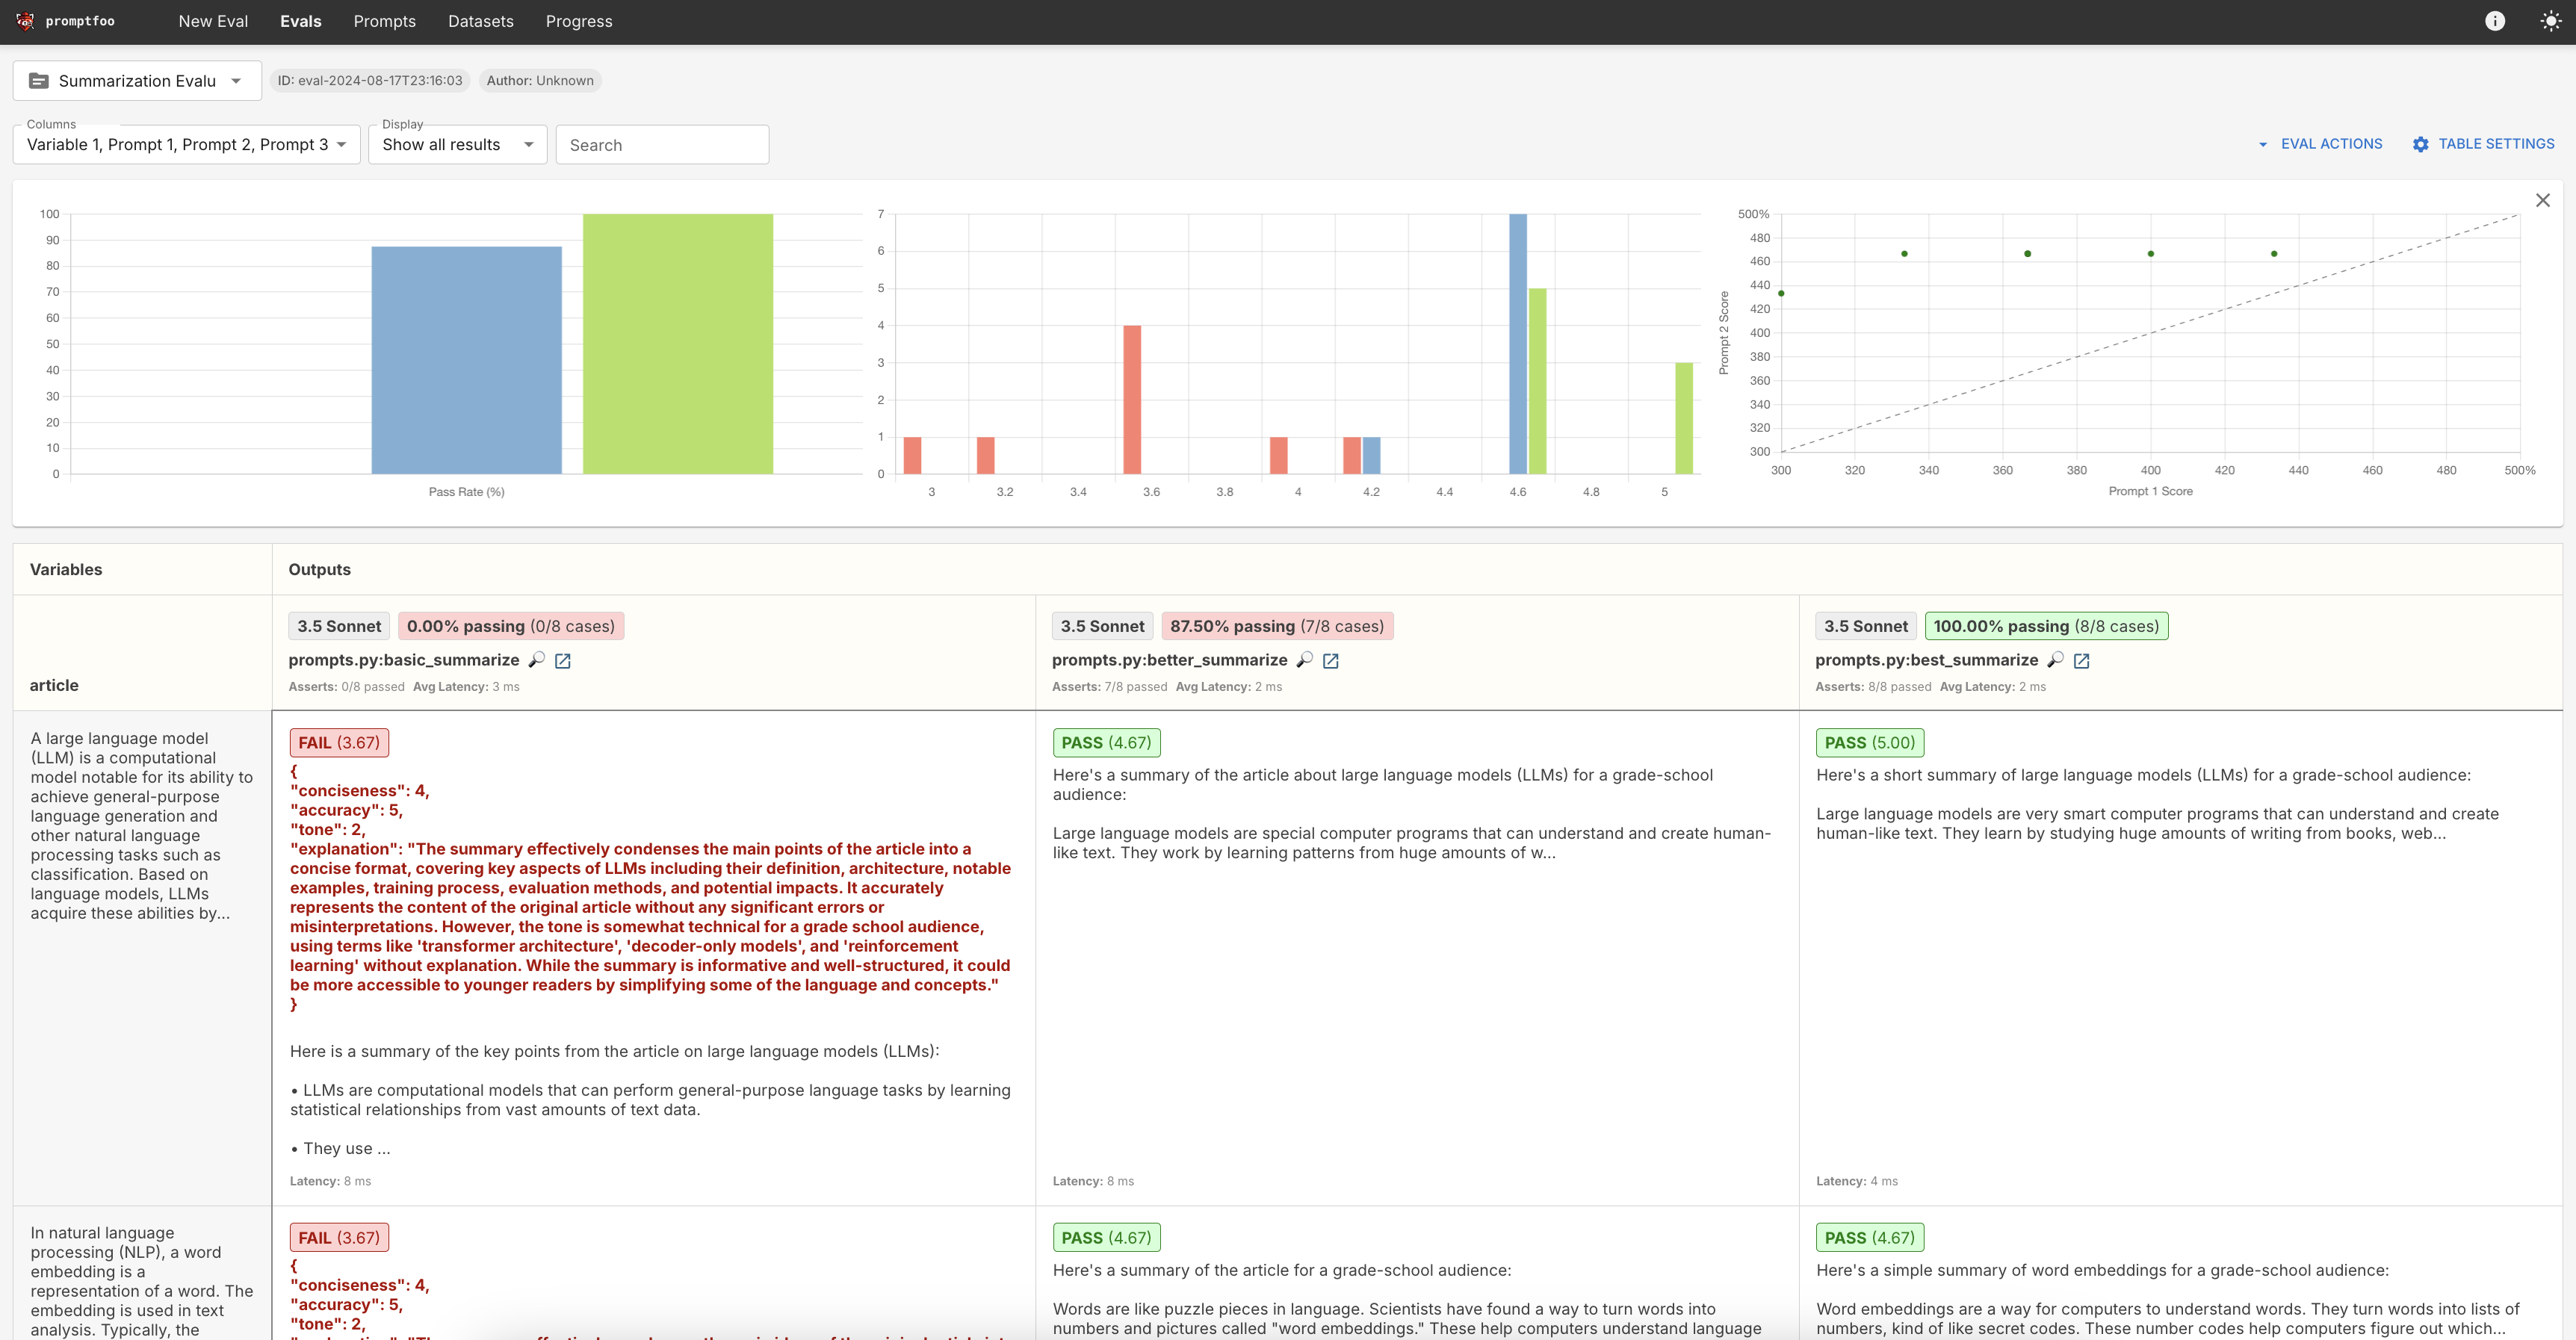

We can click on the magnifying glass in each cell to view more information on the test results:

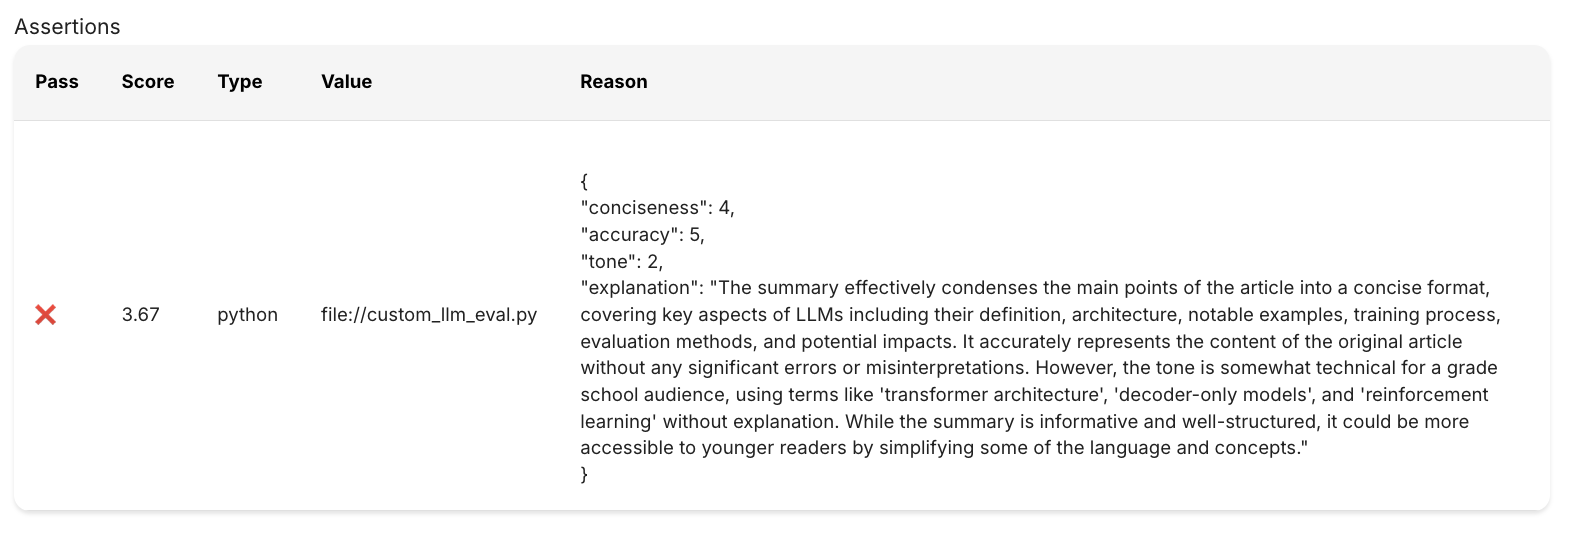

We can see that this particular output failed our custom llm-eval function because its tone score is so low.

Additionally, the top row of the results shows a summary of the grades for each prompt: 

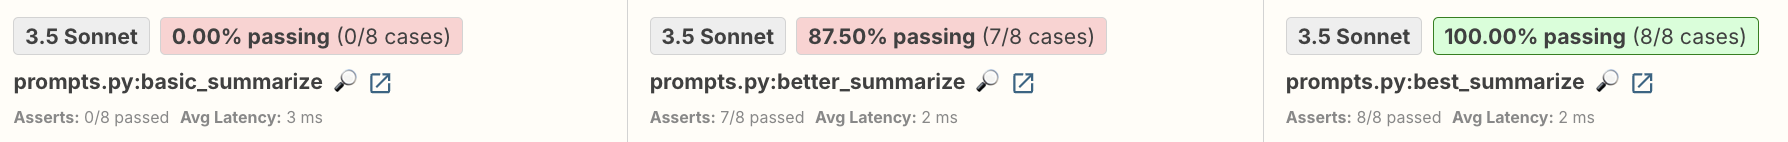

Our `best_summary` prompt is, unsurprisingly, performing the best!

The top of the dashboard also displays some charts to help visualize scores:

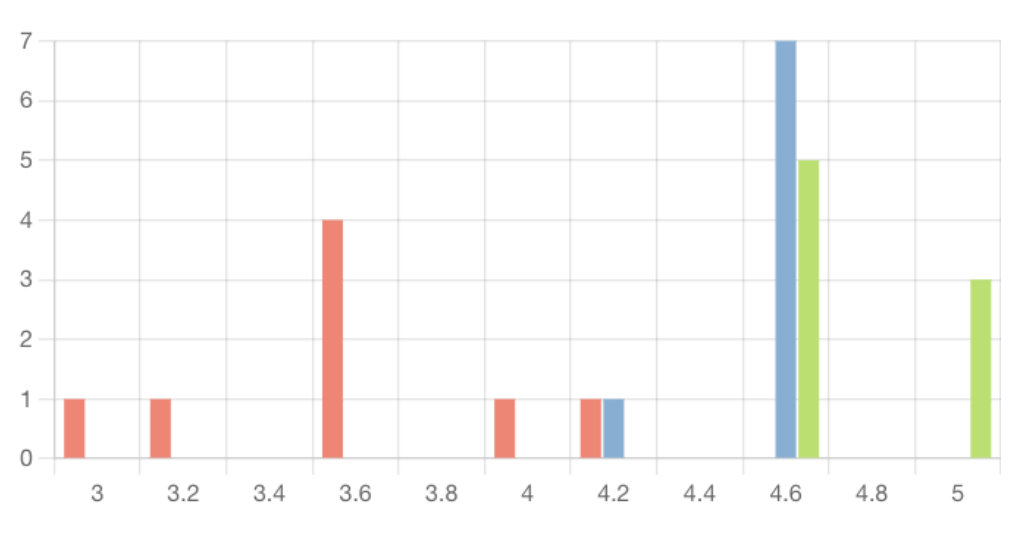

In the above screenshot:

* the red is our `basic_summarize` prompt
* the blue is our `better_summarize` prompt
* the green is our `best_summarize` prompt

The chart shows us that not only is the `best_summarize` prompt never failing our test, it outscores the other prompts on all inputs.